<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/2d_visualizasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
data_training = pd.read_csv('needs_scan_panel_training.csv', header=None)
data_test = pd.read_csv('needs_scan_panel_test.csv', header=None)
X_needs = data_training.values
test_needs = data_test.values
print(X_needs)
print(test_needs)

[[1 0 1 ... 1 1 0]
 [1 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]]
[[  1   1   0]
 [  2   4   0]
 [  2   8   0]
 ...
 [993   1   0]
 [993   2   1]
 [995   8   0]]


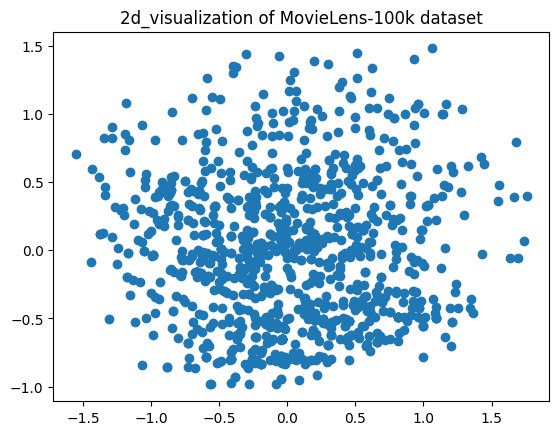

In [ ]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_needs)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0],principalValue[:,1])
plt.title("2d_visualization of MovieLens-100k dataset")
plt.rcParams["font.size"] = 12

In [ ]:
# 主成分考察（出てきた主成分は何者なのか）
import numpy as np

print(principalValue)

pv1 = principalValue[:,0]
pv2 = principalValue[:,1]

print(np.where(pv1<-1.5))
print(np.where(pv1>1.5))

X_needs_ave = np.average(X_needs, axis=1) # 各ユーザーの平均評価値
print(X_needs_ave.shape)

X_needs_ave -= np.average(X_needs_ave)
print(X_needs_ave[np.where(pv1<-1.5)])
print(X_needs_ave[np.where(pv1>1.5)])

X_needs_var = np.var(X_needs, axis=1)


# print(X_needs[np.where(p<-1.5)])
# print(X_needs[np.where(pv1>1.5)])

# print(ave[np.where(pv1<-40)])
# print(ave[np.where(pv1>60)])

[[ 0.04488577  0.14720894]
 [-0.19371077 -0.75340628]
 [ 1.75859059  0.39580429]
 ...
 [ 0.30838928  0.08596429]
 [-0.72965603 -0.68059552]
 [-0.02140393  0.35335904]]
(array([169]),)
(array([  2, 109, 202, 284, 503, 703, 860, 946]),)
(996,)
[0.42508925]
[-0.35268853 -0.35268853 -0.29713298 -0.40824409 -0.29713298 -0.40824409
 -0.24157742 -0.35268853]


In [ ]:
#RCCMM
import sys
import random
import numpy as np


def RCCMM_CF(X, C, a, b):
  n, m = X.shape
  u = np.zeros((C,n))
  w = np.zeros((C,m))
  s = np.zeros((C,n))
  r = np.zeros((n,m))
  r_ = np.zeros((n,m))

  for i in range(C):
    t=random.randint(0,n-1)
    w[i] = X[t] + sys.float_info.epsilon
  w /= w.sum(1)[:,np.newaxis]

  for step in range(100):
    u_old = u.copy()
    u = np.zeros((C,n))

    s = np.log(w) @ X.T

    s_max = s.max(0)
    u = (s >= a * s_max + b).astype(np.float64)
    u /= u.sum(0)

    w = (u @ X) + sys.float_info.epsilon
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(u - u_old).max() == 0:
      break

  if any(u.sum(1) == 0):
    raise Exception('要素数0のクラスター発生')

  r = u.T @ w
  r_ = u.T @ np.log(w)

  return r, r_, u

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


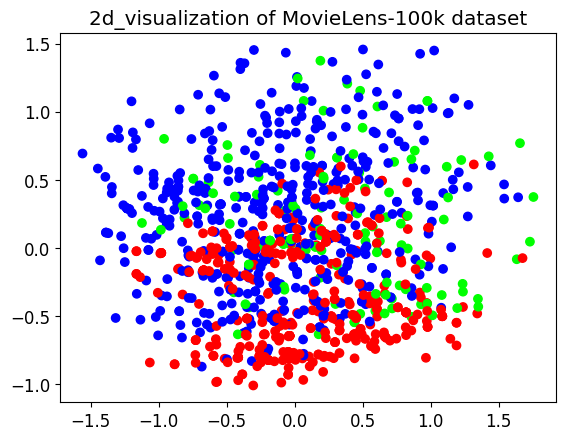

In [ ]:
r, r_, u = RCCMM_CF(X_needs, 3, 1, 0)
print(u.T)

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_needs)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1], color=u.T)
plt.title("2d_visualization of MovieLens-100k dataset")
plt.rcParams["font.size"] = 12

In [ ]:
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    normalized_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u /= normalized_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, normalized_u, (u @ R.T) / np.sum(R, 1)

(3, 996)
(996, 3)
(996, 2)


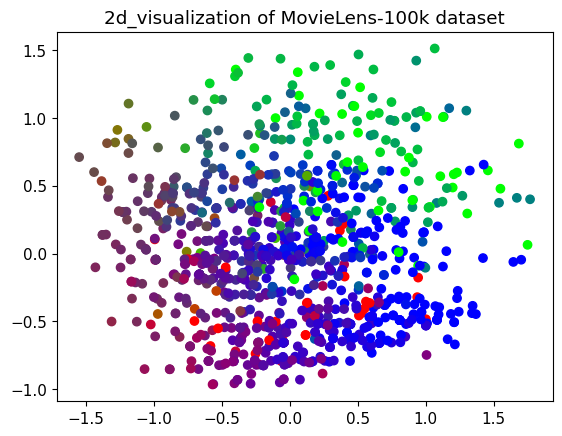

In [ ]:
r, u, rm = RSCCMM(X_needs, 3, -6)
print(rm.shape)
print(u.T.shape)
print(principalValue.shape)
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_needs)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1], color=rm.T)
plt.title("2d_visualization of MovieLens-100k dataset")
plt.rcParams["font.size"] = 11

In [ ]:
#movielensデータ
data_training = pd.read_csv('100k_Movie_training.csv', header=None)
data_test = pd.read_csv('100k_Movie_test.csv', header=None)
X_movie = data_training.values
test_movie = data_test.values
test_movie = test_movie.astype(np.int64)
test_movie_num, test_movie_num_fact = test_movie.shape
print(X_movie)
print(test_movie)

[[1.  0.  0.5 ... 0.5 0.5 0.5]
 [1.  0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 1.  0.5 0.5]]
[[651 256   0]
 [397 151   1]
 [459 155   0]
 ...
 [169 124   0]
 [613  77   1]
 [620 436   0]]


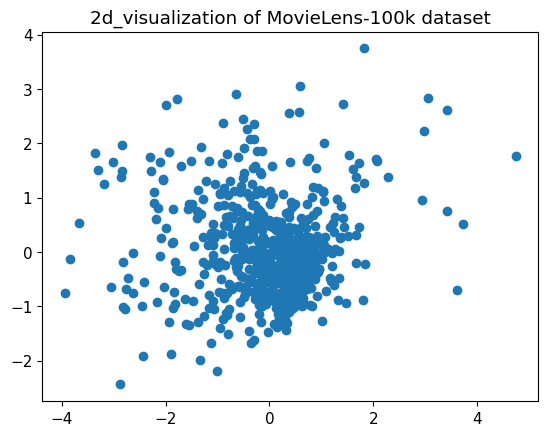

In [ ]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_movie)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1])
plt.title("2d_visualization of MovieLens-100k dataset")
plt.rcParams["font.size"] = 11

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


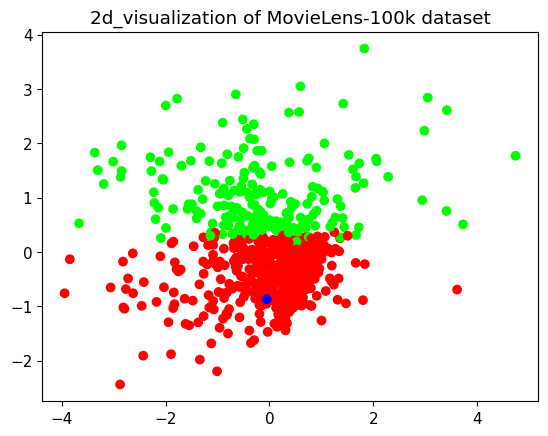

In [ ]:
r, r_, u = RCCMM_CF(X_movie, 3, 1, 0)
print(u.T)

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_movie)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1], color=u.T)
plt.title("2d_visualization of MovieLens-100k dataset")
plt.rcParams["font.size"] = 11

[[0.         0.24927536 0.25454545 ... 0.         0.24927536 1.        ]
 [1.         0.31014493 0.31212121 ... 0.5        0.31014493 0.        ]
 [0.         0.44057971 0.43333333 ... 0.5        0.44057971 0.        ]]
(690, 2)


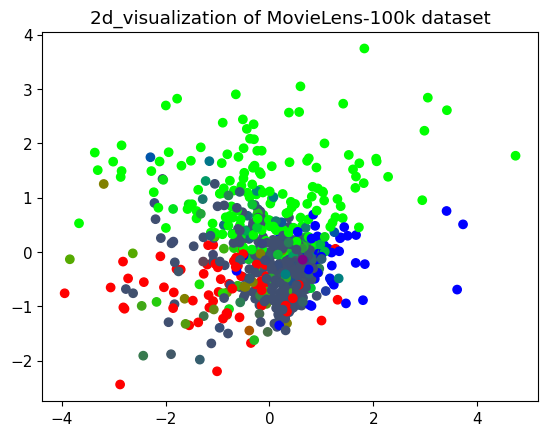

In [ ]:
r, u, rm = RSCCMM(X_movie, 3, -7.7)
print(rm)
print(principalValue.shape)

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_movie)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1], color=rm.T)
plt.title("2d_visualization of MovieLens-100k dataset")
plt.rcParams["font.size"] = 11

In [ ]:
# キムさんデータ

import numpy as np
import pandas as pd

data_training = pd.read_excel('data_training.xlsx', index_col=0, header=None)
data_test = pd.read_excel('data_test.xlsx', index_col=0)

In [ ]:
X_ORIGINAL = data_training.values[1:, 1:]
TEST = data_test.values

print(X_ORIGINAL)
print(TEST)

[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
[[343 275   5]
 [ 99 780   5]
 [648 210   4]
 ...
 [346 173   3]
 [  6 523   5]
 [ 83 623   4]]


In [ ]:
# user's average
ave = np.empty((X_ORIGINAL.shape[0]))
for n in range(X_ORIGINAL.shape[0]):
    n_sum = 0
    for m in range(r.shape[1]):
        n_sum += r[n][m]
    if n_sum == 0:
        ave[n] = 0
    else:
        ave[n] = n_sum/np.count_nonzero(r,axis=1)[n]

print(ave.shape)

X_ave = np.asarray(r, dtype = "float")

# fixed data
for n in range(X_ORIGINAL.shape[0]):
  for m in range(X_ORIGINAL.shape[1]):
    if r[n][m] == 0:
      X_ave[n][m] = ave[n]

print(X_ave)

(943,)
[[5.         3.         4.         ... 3.61065574 3.61065574 3.61065574]
 [4.         3.75438596 3.75438596 ... 3.75438596 3.75438596 3.75438596]
 [2.80392157 2.80392157 2.80392157 ... 2.80392157 2.80392157 2.80392157]
 ...
 [5.         4.04761905 4.04761905 ... 4.04761905 4.04761905 4.04761905]
 [4.27027027 4.27027027 4.27027027 ... 4.27027027 4.27027027 4.27027027]
 [3.42361111 5.         3.42361111 ... 3.42361111 3.42361111 3.42361111]]


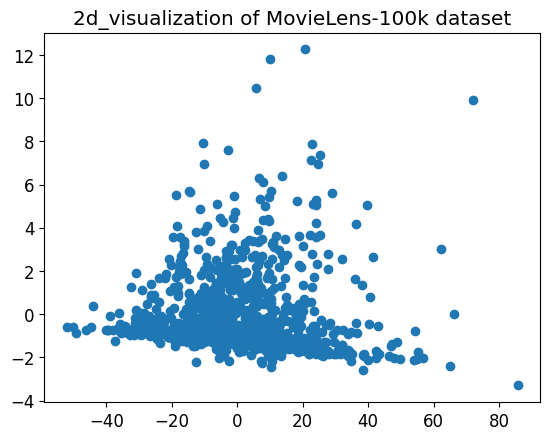

In [ ]:
data = X_ave

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# 주성분으로 이루어진 데이터 프레임 구성
principalValue = principalDf.values


plt.scatter(principalValue[:,0],principalValue[:,1])
plt.title("2d_visualization of MovieLens-100k dataset")
plt.rcParams["font.size"] = 12

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


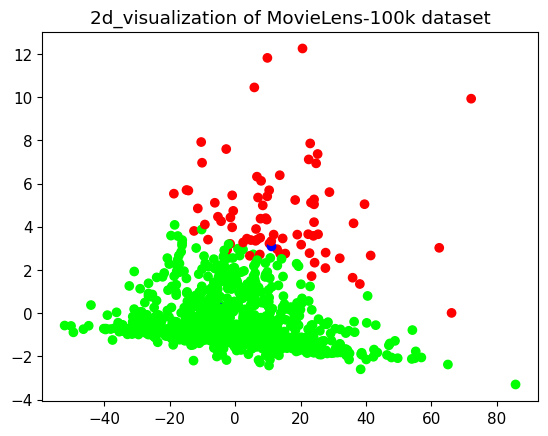

In [ ]:
r, r_, u = RCCMM_CF(data, 3, 1, 0)
print(u.T)

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1], color=u.T)
plt.title("2d_visualization of MovieLens-100k dataset")
plt.rcParams["font.size"] = 11

[[1.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         1.         0.        ]
 ...
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [1.         0.         0.        ]]


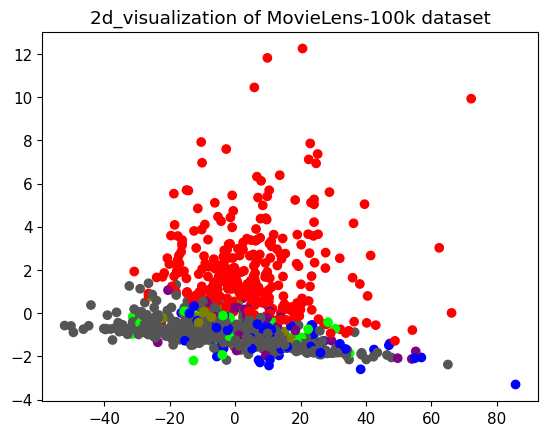

In [ ]:
r, u = RSCCMM(data, 3, -7.429)
print(u.T)

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1], color=u.T)
plt.title("2d_visualization of MovieLens-100k dataset")
plt.rcParams["font.size"] = 11